#### Background
This notebook seeks to quantify the value of leaving a certain number of tiles in the bag during the pre-endgame based on a repository of games. We will then implement these values as a pre-endgame heuristic in the Macondo speedy player to improve simulation quality.

Initial questions:
1. What is the probability that you will go out first if you make a play leaving N tiles in the bag?
2. What is the expected difference between your end-of-turn spread and end-of-game spread?
2. What's your win probability?

#### Implementation details
Similar

#### Assumptions
* We're only analyzing complete games

#### Next steps
* Standardize sign convention for spread.
* Start figuring out how to calculate pre-endgame spread

#### Quackle values for reference
* 0,0.0
* 1,-8.0
* 2,0.0
* 3,-0.5
* 4,-2.0
* 5,-3.5
* 6,-2.0
* 7,2.0
* 8,10.0,
* 9,7.0,
* 10,4.0,
* 11,-1.0,
* 12,-2.0

#### Runtime
I was able to run this script on my local machine for ~20M rows in 2 minutes.

In [31]:
import csv
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_folder = '../logs/'
log_file = log_folder + 'log_20200515_preendgames.csv'

todays_date = date.today().strftime("%Y%m%d")

In [2]:
final_spread_dict = {}
out_first_dict = {}
win_dict = {}

Store the final spread of each game for comparison. The assumption here is that the last row logged is the final turn of the game, so for each game ID we overwrite the final move dictionary until there are no more rows from that game

In [3]:
t0 = time.time()

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))
            
        if i<10:
            print(row)
            
        if row[0]=='p1':
            final_spread_dict[row[1]] = int(row[6])-int(row[11])
        else:
            final_spread_dict[row[1]] = int(row[11])-int(row[6])
            
        out_first_dict[row[1]] = row[0]
        
        # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
        win_dict[row[1]] = (np.sign(final_spread_dict[row[1]])+1)/2

['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '1', 'CEIIORT', '8H TORIC', '20', '20', '5', 'EI', '21.853', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '2', 'CDEIIJW', '9G JEW', '36', '36', '3', 'CDII', '33.265', '81', '20']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '3', 'EFIMOQT', '10F MOTE', '30', '50', '4', 'FIQ', '21.483', '78', '36']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '4', 'ACDHIII', 'L7 A.IDIC', '22', '58', '5', 'HI', '22.994', '74', '50']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '5', 'BEFGIOQ', '11C BEFOG', '37', '87', '5', 'IQ', '32.050', '69', '58']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '1', 'DEIOSTW', '8D WITED', '26', '26', '5', 'OS', '32.236', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '6', 'AHIOORV', '12D HAO', '32', '90', '3', 'IORV', '29.935', '64', '87']
['p1', 'wvTRHqNYEEjCHJiuGDw3WM', '2', 'DENRTWZ', 'E7 W.ZEN', '34', '34', '4', 'DRT', '34.836', '81', '26']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '7', 'AINQRTV', 'J10 TRANQ', '45', '132', '5', 'IV', '40.426', '61', '90']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '3', 'AB

In [54]:
preendgame_boundaries = [1,42] # how many tiles are in the bag before we count as pre-endgame?
leftover_tile_range = range(preendgame_boundaries[0],preendgame_boundaries[1]+1)

end_of_turn_spread_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}
final_spread_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}
game_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}
out_first_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}
# start_of_turn_tiles_left_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}
win_counter = {remaining_tile_count:0 for remaining_tile_count in leftover_tile_range}

In [55]:
t0=time.time()
print('There are {} games'.format(len(final_spread_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))
            
        end_of_turn_tiles_left = int(row[10])-int(row[7])+7

        if end_of_turn_tiles_left >= preendgame_boundaries[0] and end_of_turn_tiles_left <= preendgame_boundaries[1]:
            end_of_turn_spread_counter[end_of_turn_tiles_left] += int(row[6])-int(row[11])
            game_counter[end_of_turn_tiles_left] += 1        
            out_first_counter[end_of_turn_tiles_left] += out_first_dict[row[1]] == row[0]
            
            if row[0]=='p1':
                final_spread_counter[end_of_turn_tiles_left] += final_spread_dict[row[1]]
                win_counter[end_of_turn_tiles_left] += win_dict[row[1]]
            else:
                final_spread_counter[end_of_turn_tiles_left] -= final_spread_dict[row[1]]
                win_counter[end_of_turn_tiles_left] += (1-win_dict[row[1]])

There are 817267 games
Processed 1000000 rows in 3.1808559894561768 seconds
Processed 2000000 rows in 6.3960020542144775 seconds
Processed 3000000 rows in 9.65578007698059 seconds
Processed 4000000 rows in 12.869065046310425 seconds
Processed 5000000 rows in 16.12370204925537 seconds
Processed 6000000 rows in 19.525557279586792 seconds
Processed 7000000 rows in 22.80394196510315 seconds
Processed 8000000 rows in 26.042148113250732 seconds
Processed 9000000 rows in 29.904803037643433 seconds
Processed 10000000 rows in 33.804190158843994 seconds
Processed 11000000 rows in 37.278908014297485 seconds
Processed 12000000 rows in 40.68167495727539 seconds
Processed 13000000 rows in 44.13261604309082 seconds
Processed 14000000 rows in 48.22230410575867 seconds
Processed 15000000 rows in 51.64091897010803 seconds
Processed 16000000 rows in 54.91535925865173 seconds
Processed 17000000 rows in 58.19640111923218 seconds
Processed 18000000 rows in 61.48505210876465 seconds


In [56]:
end_of_turn_spread_series = pd.Series(end_of_turn_spread_counter,name='end_of_turn_spread')
final_spread_series = pd.Series(final_spread_counter,name='final_spread')
game_series = pd.Series(game_counter,name='count')
out_first_series = pd.Series(out_first_counter, name='out_first_count')
win_series = pd.Series(win_counter, name='win_count')

In [57]:
df = pd.concat([end_of_turn_spread_series, final_spread_series, game_series,
                out_first_series, win_series],axis=1)

In [58]:
df['spread_delta'] = df['final_spread']-df['end_of_turn_spread']
df['avg_spread_delta'] = df['spread_delta']/df['count']
df['out_first_pct'] = 100*df['out_first_count']/df['count']
df['win_pct'] = 100*df['win_count']/df['count']

In [59]:
quackle_peg_dict = {
    1:-8.0,
    2:0.0,
    3:-0.5,
    4:-2.0,
    5:-3.5,
    6:-2.0,
    7:2.0,
    8:10.0,
    9:7.0,
    10:4.0,
    11:-1.0,
    12:-2.0
}

quackle_peg_series = pd.Series(quackle_peg_dict, name='quackle_values')

In [60]:
df = pd.concat([df,quackle_peg_series],axis=1)

In [61]:
df['quackle_macondo_delta'] = df['quackle_values']-df['avg_spread_delta']

In [62]:
df = df.reset_index().rename({'index':'tiles_left_after_play'}, axis=1)

In [63]:
df

tiles_left_after_play  end_of_turn_spread  final_spread   count  \
0                       1             2584950       -138134  193090   
1                       2             4869275       -167949  363028   
2                       3             7376835        208220  486274   
3                       4             9202012        842544  588925   
4                       5             7720501        -47604  617635   
5                       6             5030287      -1226130  468590   
6                       7             3688236       -412332  220456   
7                       8             3670547        931117  210489   
8                       9             3798585        812144  209899   
9                      10             3788064        358082  209460   
10                     11             3808574        -55173  208724   
11                     12             3727206       -316276  206998   
12                     13             3716771       -275176  206500   
13                     14             3809135        -27364  205137   
14                     15             3845568        -12775  203808   
15                     16             3723763         -4582  203466   
16                     17             3758440         69714  202546   
17                     18             3763532         74103  201429   
18                     19             3841516         75509  201231   
19                     20             3805593         16111  200598   
20                     21             3821523        -35855  199393   
21                     22             3816506        -45511  198477   
22                     23             3831688        -26897  197716   
23                     24             3859041         22524  197254   
24                     25             3833905         37791  196895   
25                     26             3765545         18461  195145   
26                     27             3778934         -6284  195846   
27                     28             3835867        -25359  195386   
28                     29             3775389        -40108  194736   
29                     30             3802381        -73851  193136   
30                     31             3891797         11056  193723   
31                     32             3852338         10107  193236   
32                     33             3856204         65077  192943   
33                     34             3863644         37621  192290   
34                     35             3818345         12953  191157   
35                     36             3810388         15317  190831   
36                     37             3793708        -21838  190590   
37                     38             3824918        -27673  190381   
38                     39             3847240        -59513  190275   
39                     40             3891603         35659  188747   
40                     41             3821660        -17772  188791   
41                     42             3816175         73191  188492   

    out_first_count  win_count  spread_delta  avg_spread_delta  out_first_pct  \
0            139335    95801.5      -2723084        -14.102667      72.160650   
1            228521   180795.5      -5037224        -13.875580      62.948588   
2            263203   244043.0      -7168615        -14.741925      54.126480   
3            302620   298262.0      -8359468        -14.194453      51.385151   
4            338494   309145.0      -7768105        -12.577177      54.804860   
5            260076   229800.5      -6256417        -13.351580      55.501825   
6             61325   108957.5      -4100568        -18.600392      27.817342   
7             83786   108728.5      -2739430        -13.014599      39.805406   
8            107310   107768.5      -2986441        -14.227991      51.124588   
9            120511   105784.0      -3429982        -16.375356      57.534135   
10           120659   104005.5      -3863747        -18.511

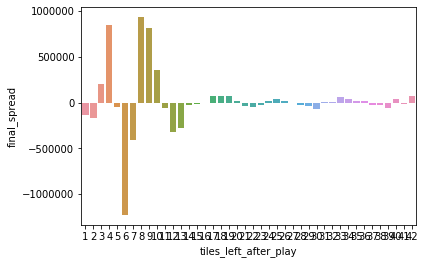

In [64]:
sns.barplot(x='tiles_left_after_play',y='final_spread',data=df)

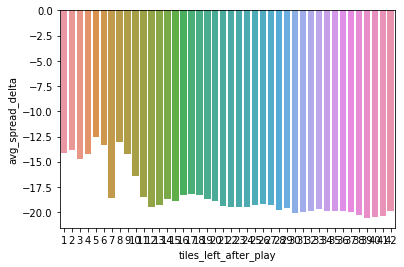

In [67]:
sns.barplot(x='tiles_left_after_play',y='avg_spread_delta',data=df)

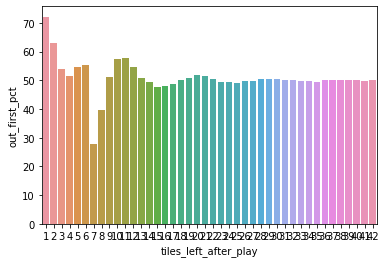

In [66]:
sns.barplot(x='tiles_left_after_play',y='out_first_pct',data=df)

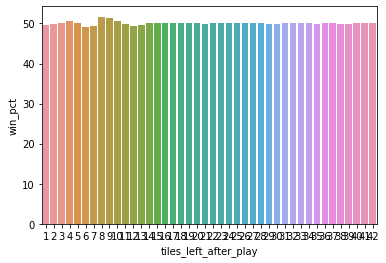

In [65]:
sns.barplot(x='tiles_left_after_play',y='win_pct',data=df)

Save a summary and a verbose version of preendgame heuristic values.

In [53]:
df['avg_spread_delta'].to_csv('peg_heuristics_' + todays_date + '.csv')
df.to_csv('peg_summary_' + todays_date + '.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
